<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [1]:
import numpy as np
import seaborn as sns
import torch
from matplotlib import pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from torch import nn
from torch.nn import functional as Func
from torch.utils.data import DataLoader, TensorDataset

sns.set(style="darkgrid", font_scale=1.4)
from IPython.display import set_matplotlib_formats

set_matplotlib_formats("retina")

C:\Users\ryblo\AppData\Local\Temp\ipykernel_4664\498646779.py:14: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats("retina")


# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [2]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

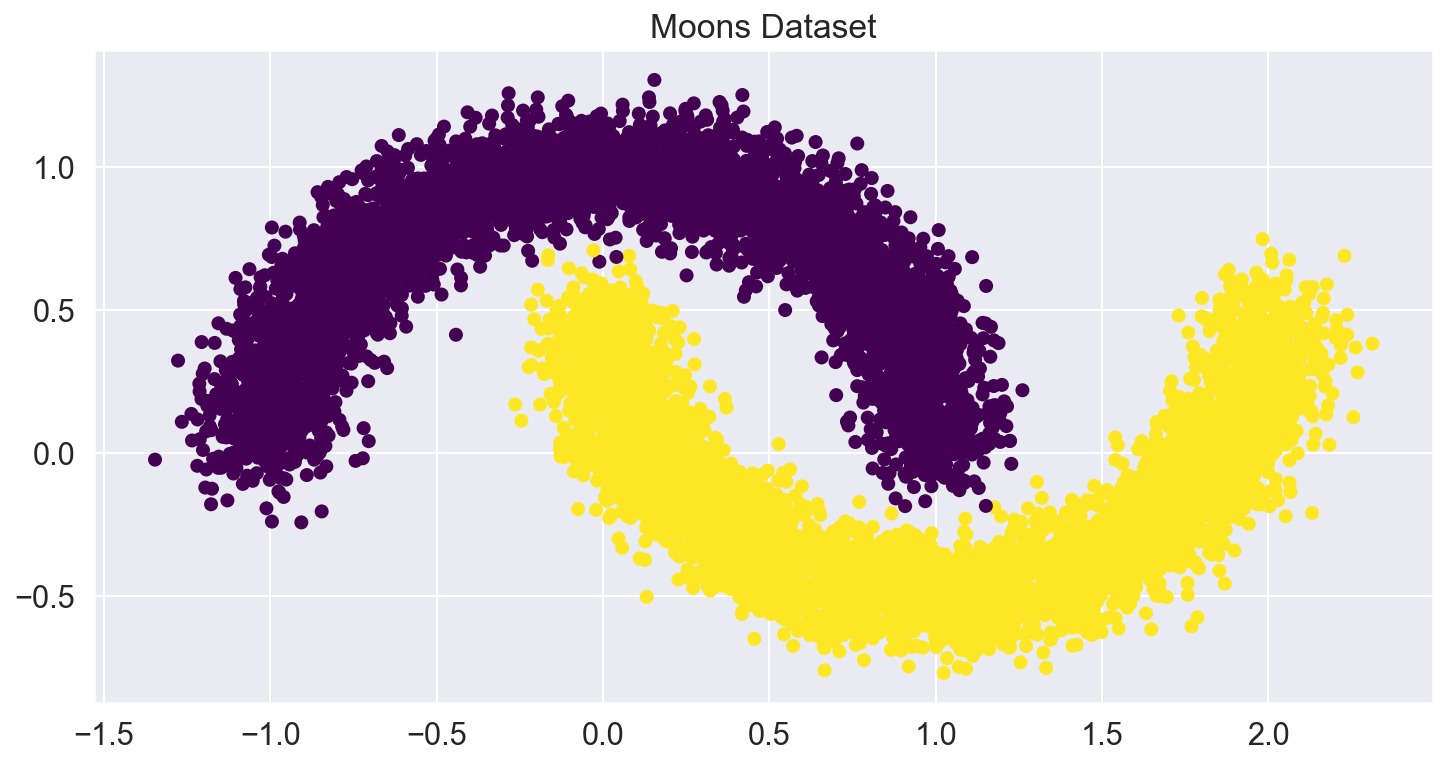

In [3]:
plt.figure(figsize=(12, 6))
plt.title("Moons Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

#### Задание. Создайте тензоры с обучающими и тестовыми данными

In [5]:
X_train_t = torch.FloatTensor(X_train)  # YOUR CODE GOES HERE
y_train_t = torch.FloatTensor(y_train)  # YOUR CODE GOES HERE
X_val_t = torch.FloatTensor(X_val)  # YOUR CODE GOES HERE
y_val_t = torch.FloatTensor(y_val)  # YOUR CODE GOES HERE

Создаем `Dataset` и `DataLoader`. 

In [6]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)

train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

### Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидами. Чаще всего в качестве сигмоиды берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

#### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [7]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        # YOUR CODE GOES HERE
        self.weights = nn.Parameter(torch.randn(in_features, out_features))
        self.bias = bias
        if bias:
            # YOUR CODE GOES HERE
            self.bias_term = nn.Parameter(torch.randn(out_features, 1))

    def forward(self, x):
        x = torch.matmul(x, self.weights)
        if self.bias:
            x += self.bias_term  # YOUR CODE GOES HERE
        return x

In [8]:
dim_in = X_train_t.shape[1] # the number of features
# the number of classes. In case of such implementation it is equal to 1, 
# because we have implement linear regression and used nn.BCEWithLogitsLoss() to make it logistic regression
dim_out = 1 

In [9]:
linear_regression = LinearRegression(dim_in, dim_out)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели?

In [10]:
#YOUR CODE
list(linear_regression.parameters())

[Parameter containing:
 tensor([[-1.4174],
         [-1.8613]], requires_grad=True),
 Parameter containing:
 tensor([[-1.2112]], requires_grad=True)]

У получившейся модели 3 обучаемых параметра: матрица $W$ содержит 2 параметра и вектор $b$ состоит из 1 параметра

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

#### Задание. Реализация цикла обучения

In [11]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        # YOUR CODE. Use linear_regression to get outputs
        outp = linear_regression(X_batch)
        # YOUR CODE. Compute loss
        loss = loss_function(outp, y_batch.view(-1, 1))
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()

        # YOUR CODE. Compute probabilities
        probabilities = torch.sigmoid(linear_regression(X_batch))
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(
            torch.float32
        ).sum() / y_batch.size(0)

        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(
                f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}"
            )
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(
                f"\nIteration: {it + epoch * len(train_dataloader)}. Convergence. Stopping iterations."
            )
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.5
Iteration: 100
Batch accuracy: 0.8515625
Iteration: 200
Batch accuracy: 0.8671875
Iteration: 300
Batch accuracy: 0.921875
Iteration: 400
Batch accuracy: 0.8984375

Iteration: 460. Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** 460

### Визуализируем результаты

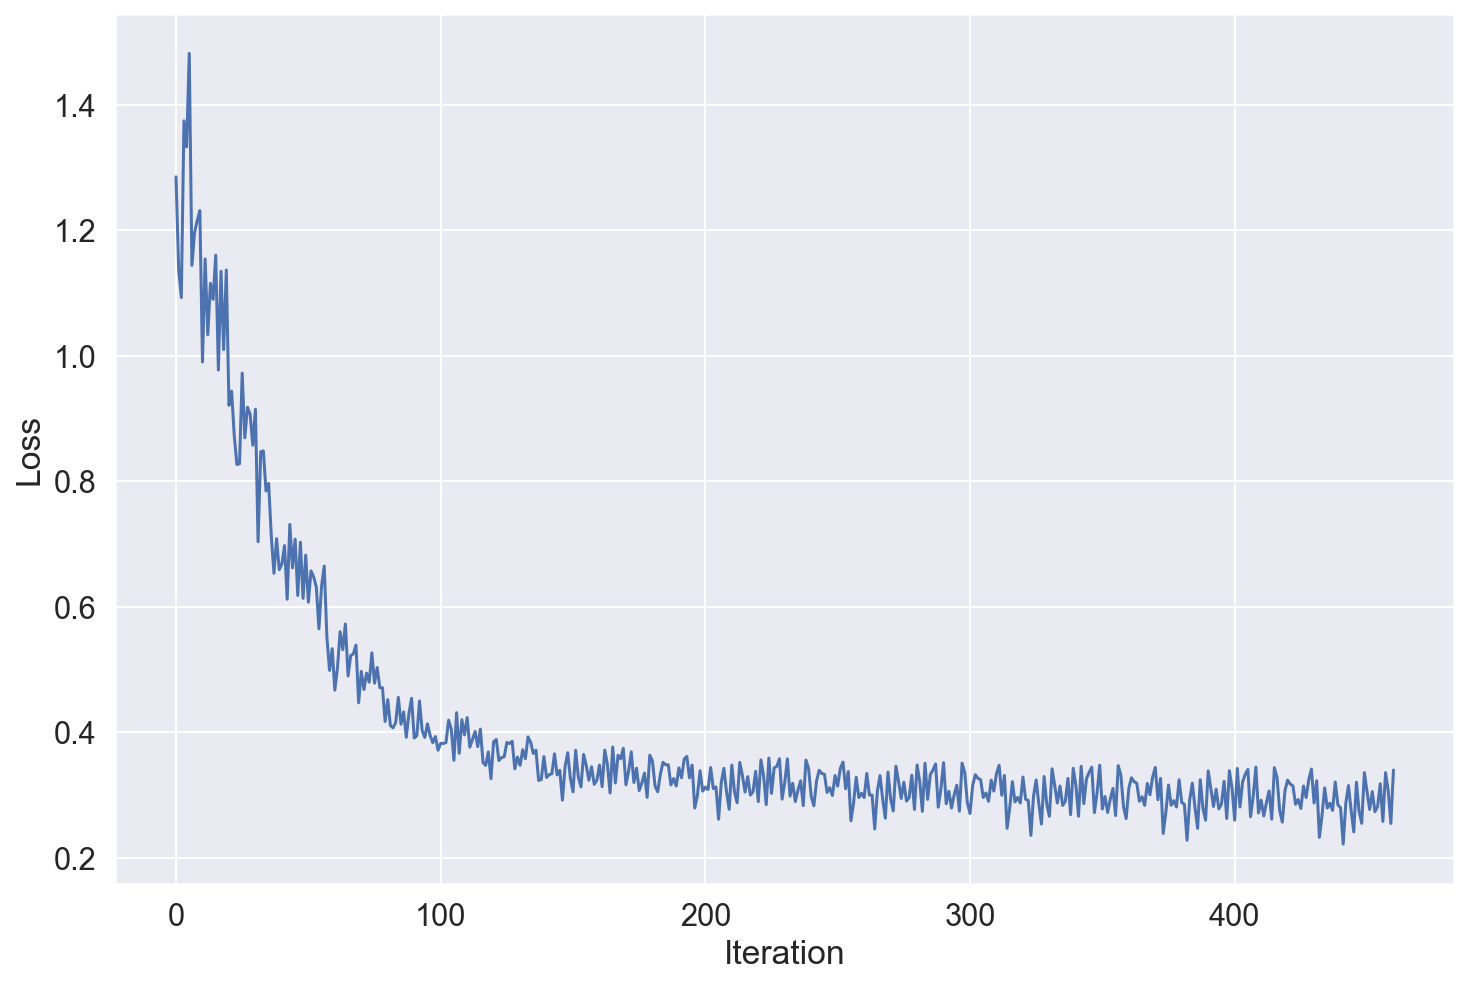

In [12]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

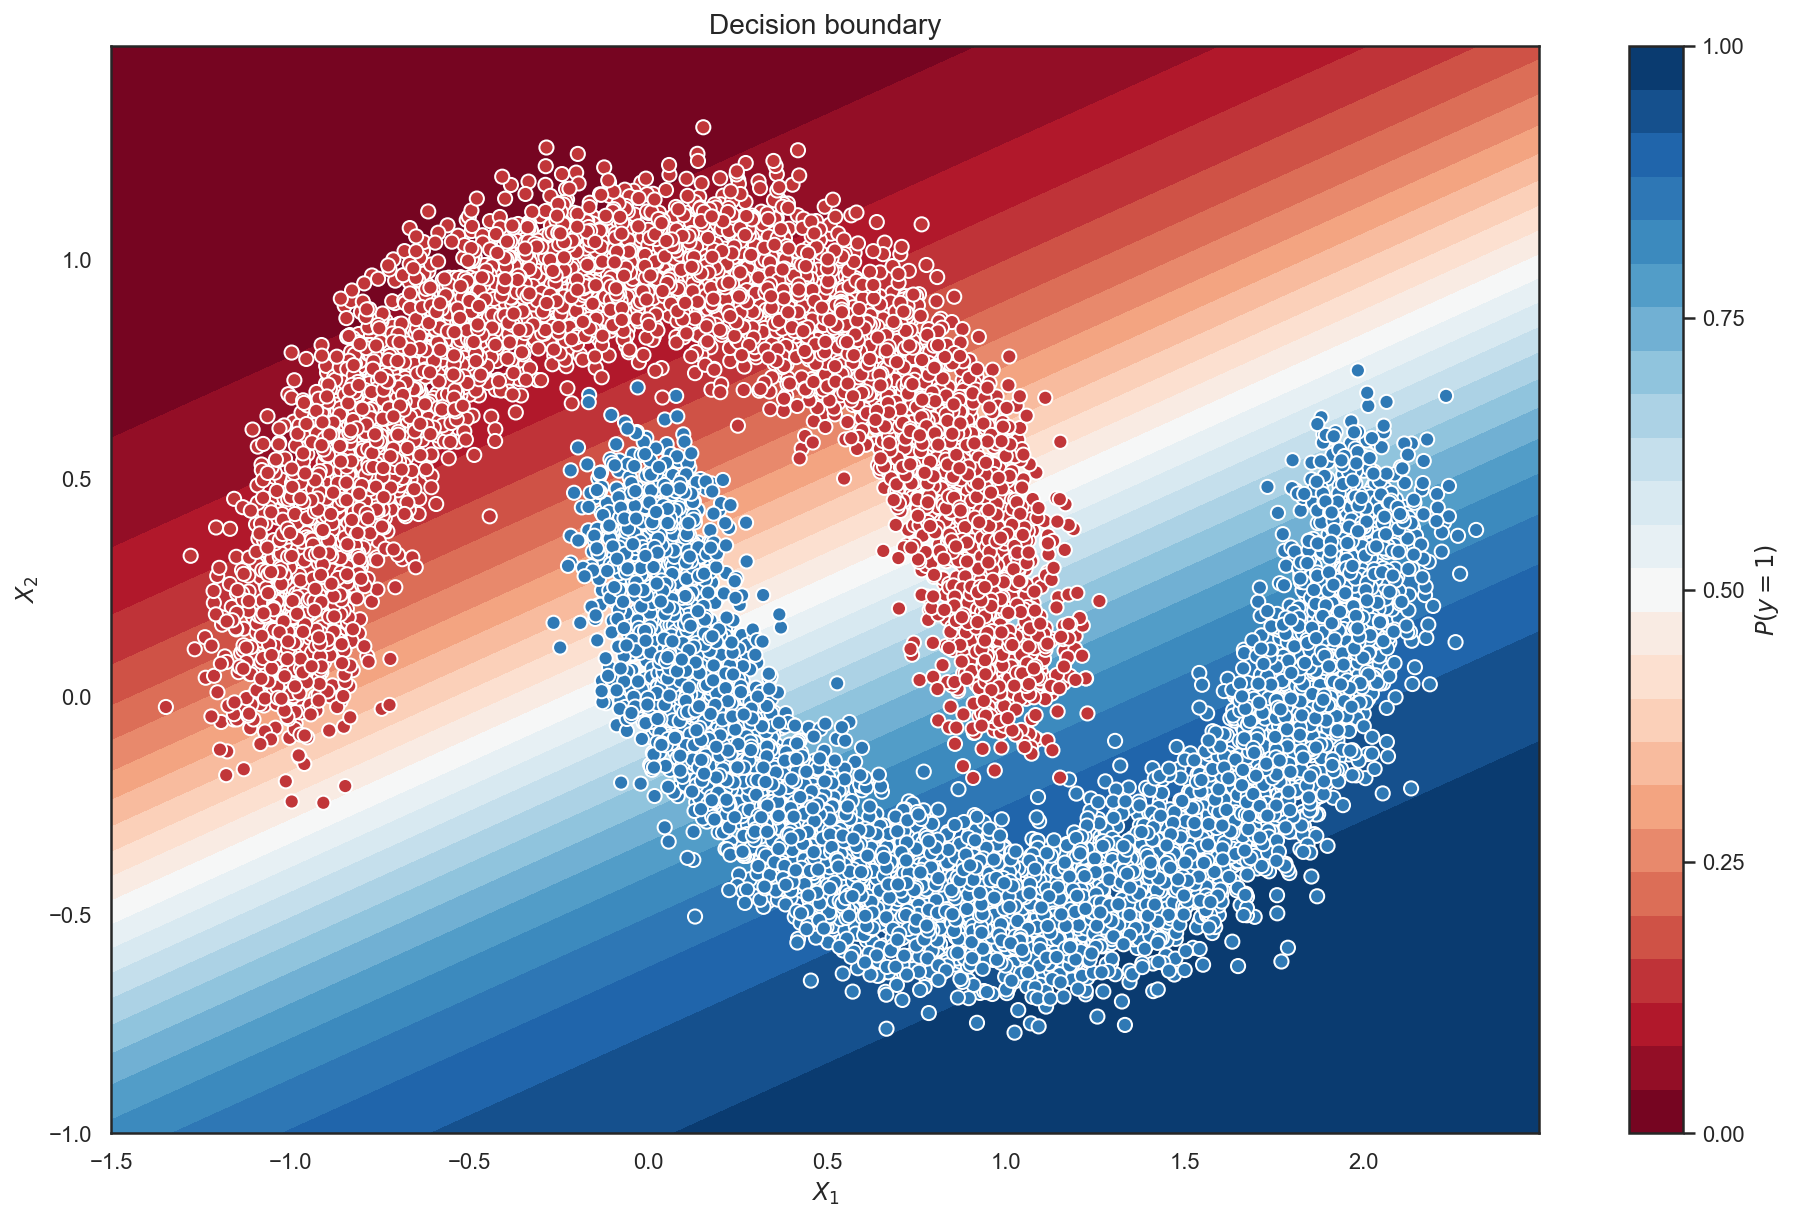

In [13]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

#### Задание. Реализуйте predict и посчитайте accuracy на test.

In [14]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        # YOUR CODE.
        probs = torch.sigmoid(model(x_batch))
        # YOUR CODE. Compute predictions
        preds = np.array(probs > 0.5)
        predictions = np.hstack((predictions, preds.flatten()))
    return predictions.flatten()

In [15]:
from sklearn.metrics import accuracy_score

# YOUR CODE. Compute total accuracy
y_pred = predict(val_dataloader, linear_regression)
print(f"Accuracy is equal to {accuracy_score(y_val, y_pred)}")

Accuracy is equal to 0.8788


**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:**  
0.8788

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [16]:
import os

import torchvision.transforms as tfs
from torchvision.datasets import MNIST

data_tfs = tfs.Compose([tfs.ToTensor(), tfs.Normalize((0.5), (0.5))])

# install for train and test
root = "./"
train_dataset = MNIST(root, train=True, transform=data_tfs, download=True)
val_dataset = MNIST(root, train=False, transform=data_tfs, download=True)

batch_size = 128

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True)
valid_dataloader = DataLoader(val_dataset, batch_size=batch_size, drop_last=True)

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [17]:
class Identical(nn.Module):
    def forward(self, x):
        return x

#### Задание. Простая полносвязная нейронная сеть 

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [19]:
features = 28 * 28
classes = 10

model = nn.Sequential(
    nn.Flatten(),
    # YOUR CODE. Add layers to your sequential class
    nn.Linear(features, 128),
    nn.ELU(),
    nn.Linear(128, 128),
    nn.ELU(),
    nn.Linear(128, classes),
)

model.to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ELU(alpha=1.0)
  (3): Linear(in_features=128, out_features=128, bias=True)
  (4): ELU(alpha=1.0)
  (5): Linear(in_features=128, out_features=10, bias=True)
)

In [20]:
criterion = nn.CrossEntropyLoss()  # YOUR CODE. Select a loss function
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

#### Задание. Дополните цикл обучения.

In [21]:
max_epochs = 10
accuracy = {"train": [], "valid": []}

In [22]:
for epoch in range(max_epochs):
    for loader, dataloader in loaders.items():

        epoch_correct = 0
        epoch_all = 0

        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            
            if loader == "train":
                # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                model.train()
                optimizer.zero_grad()
                output = model(x_batch)
            else:
                # YOUR CODE. Set model to ``eval`` mode and calculate outputs
                model.eval()
                with torch.no_grad():
                    output = model(x_batch)

            preds = output.argmax(-1)
            correct = (preds == y_batch).type(torch.float).sum() # YOUR CODE GOES HERE
            all = len(y_batch)  # YOUR CODE GOES HERE
            epoch_correct += correct.item()
            epoch_all += all

            if loader == "train":
                loss = criterion(output, y_batch)
                # YOUR CODE. Calculate gradients and make a step of your optimizer
                loss.backward()
                optimizer.step()

        if loader == "train":
            print(f"Epoch: {epoch + 1}")

        print(f"Loader: {loader}. Accuracy: {epoch_correct / epoch_all}")
        accuracy[loader].append(epoch_correct / epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.880592280982906
Loader: valid. Accuracy: 0.9292868589743589
Epoch: 2
Loader: train. Accuracy: 0.9432091346153846
Loader: valid. Accuracy: 0.9499198717948718
Epoch: 3
Loader: train. Accuracy: 0.9602196848290598
Loader: valid. Accuracy: 0.9603365384615384
Epoch: 4
Loader: train. Accuracy: 0.9686999198717948
Loader: valid. Accuracy: 0.9647435897435898
Epoch: 5
Loader: train. Accuracy: 0.9740584935897436
Loader: valid. Accuracy: 0.9676482371794872
Epoch: 6
Loader: train. Accuracy: 0.9786324786324786
Loader: valid. Accuracy: 0.9717548076923077
Epoch: 7
Loader: train. Accuracy: 0.9812032585470085
Loader: valid. Accuracy: 0.9701522435897436
Epoch: 8
Loader: train. Accuracy: 0.9836237980769231
Loader: valid. Accuracy: 0.9699519230769231
Epoch: 9
Loader: train. Accuracy: 0.9853098290598291
Loader: valid. Accuracy: 0.9728565705128205
Epoch: 10
Loader: train. Accuracy: 0.9866619925213675
Loader: valid. Accuracy: 0.9707532051282052


#### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [23]:
class NeuralNetwork(nn.Module):
    def __init__(self, features, classes, activation_function):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(features, 128),
            activation_function,
            nn.Linear(128, 128),
            activation_function,
            nn.Linear(128, classes),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [24]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct = 100 * correct / size
    print(f"Test Error: \n Accuracy: {(correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct

In [25]:
# YOUR CODE. Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)


def test_activation_function(activation):
    print(f"Testing {activation} function!")
    # YOUR CODE
    valid_acc = []


    
    criterion = nn.CrossEntropyLoss()  # YOUR CODE. Select a loss function
    optimizer = torch.optim.Adam(model.parameters())
    
    print(model)

    for t in range(max_epochs):
        print(f"Epoch {t + 1}\n-------------------------------")
        train_loop(train_dataloader, model, criterion, optimizer)
        acc = test_loop(valid_dataloader, model, criterion)
        valid_acc.append(acc)
    print("Done!")
    return valid_acc

In [26]:
activation_functions = {
    "plain": Identical(),
    "ELU": nn.ELU(),
    "ReLU": nn.ReLU(),
    "LeakyReLU": nn.LeakyReLU(),
}

accuracies = {
    "plain_accuracy": 0,
    "ReLU_accuracy": 0,
    "LeakyReLU_accuracy": 0,
    "ELU_accuracy": 0,
}

In [27]:
accuracies = {}
for activation_name, activation_func in activation_functions.items():
    model = NeuralNetwork(features, classes, activation_func)
    model.to(device)

    accuracies[f"{activation_name}_accuracy"] = test_activation_function(
        activation_func
    )

Testing Identical() function!
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): Identical()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Identical()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)
Epoch 1
-------------------------------
loss: 2.342494  [    0/60000]
loss: 0.410497  [12800/60000]
loss: 0.240740  [25600/60000]
loss: 0.497187  [38400/60000]
loss: 0.560685  [51200/60000]
Test Error: 
 Accuracy: 88.8%, Avg loss: 0.370941 

Epoch 2
-------------------------------
loss: 0.261392  [    0/60000]
loss: 0.407528  [12800/60000]
loss: 0.227210  [25600/60000]
loss: 0.391796  [38400/60000]
loss: 0.643471  [51200/60000]
Test Error: 
 Accuracy: 89.7%, Avg loss: 0.342559 

Epoch 3
-------------------------------
loss: 0.233595  [    0/60000]
loss: 0.295434  [12800/60000]
loss: 0.219929  [25600/60000]
loss: 0.357338  [38400/6000

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

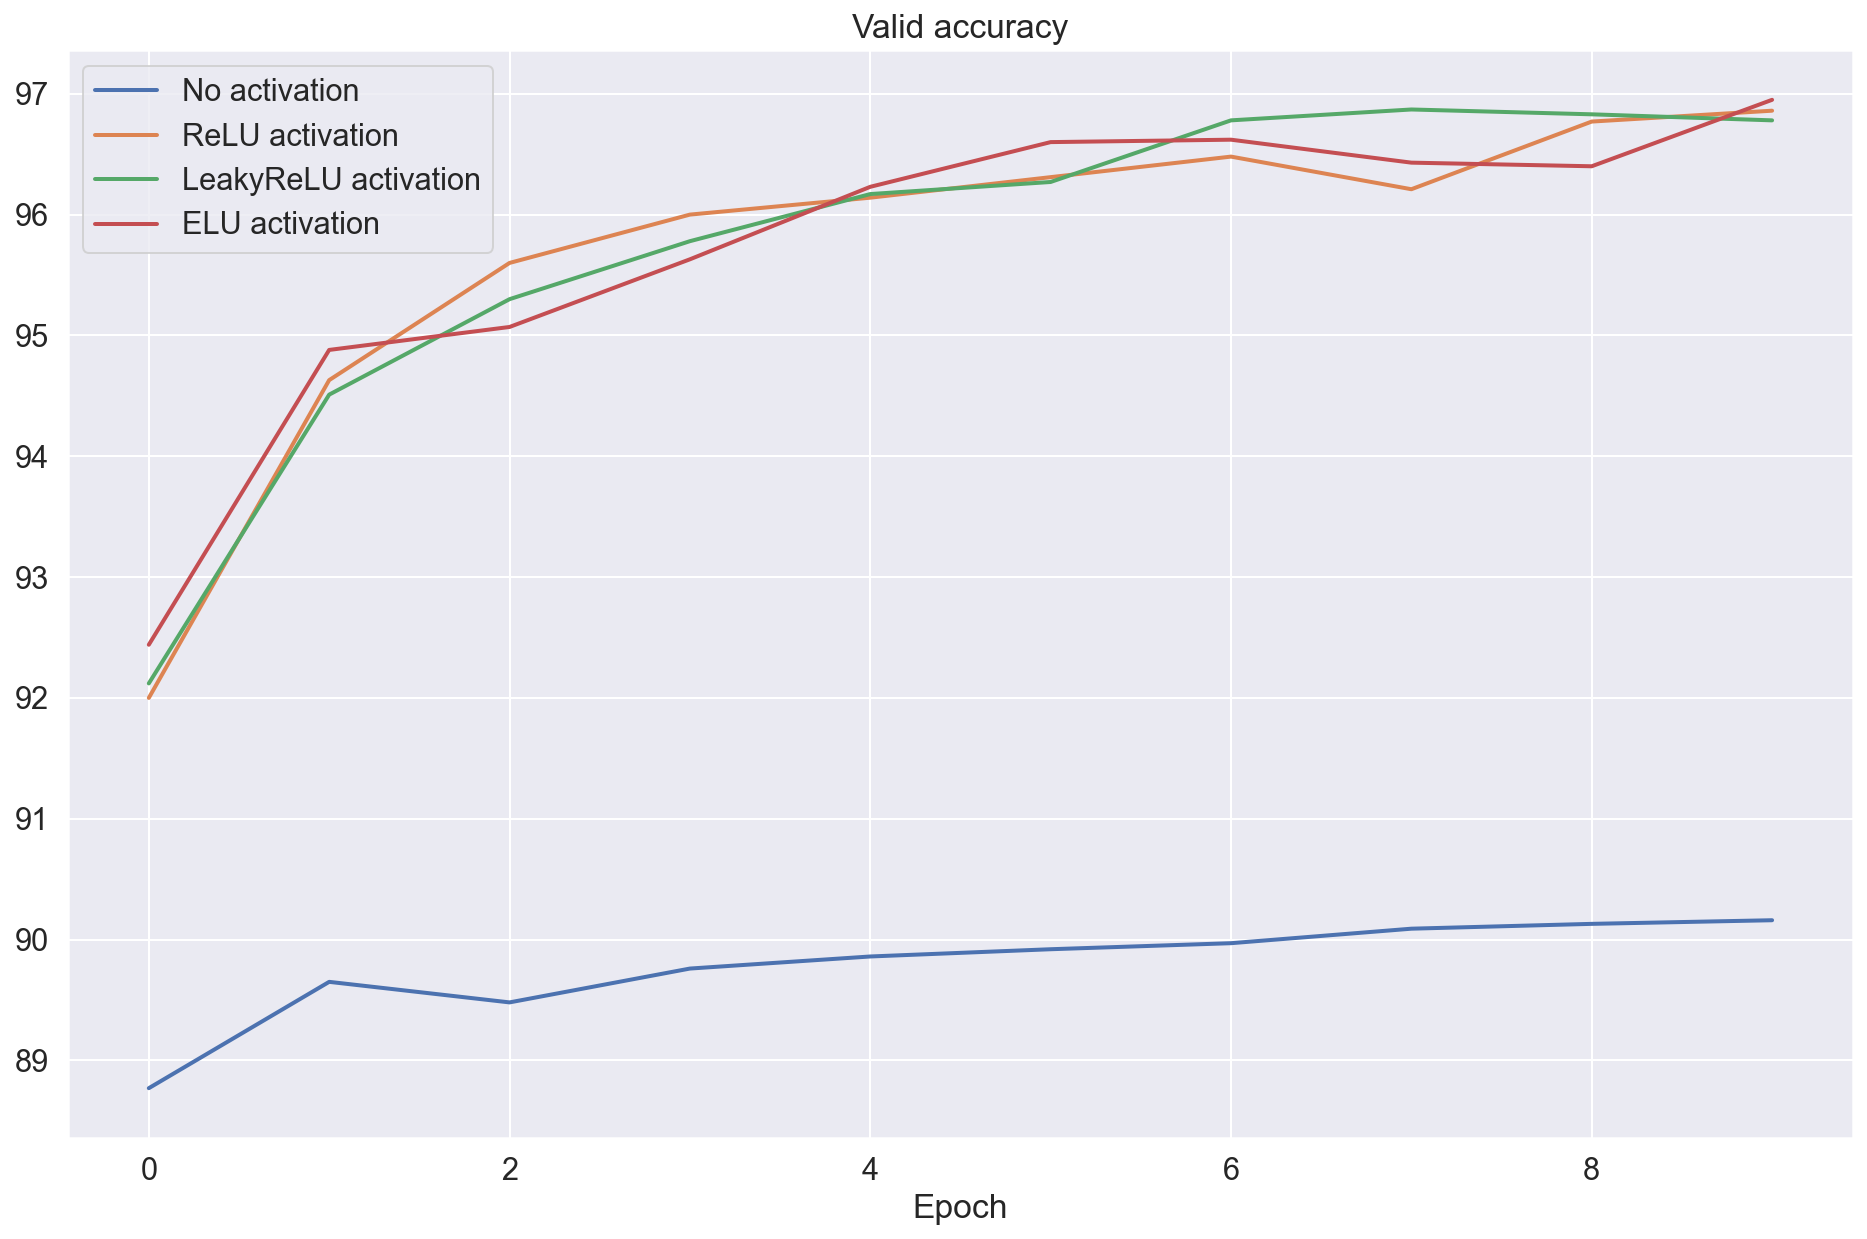

In [28]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), accuracies["plain_accuracy"], label="No activation", linewidth=2)
plt.plot(range(max_epochs), accuracies["ReLU_accuracy"], label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), accuracies["LeakyReLU_accuracy"], label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), accuracies["ELU_accuracy"], label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** ELU

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [29]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg")

In [30]:
# !pip install opencv-python

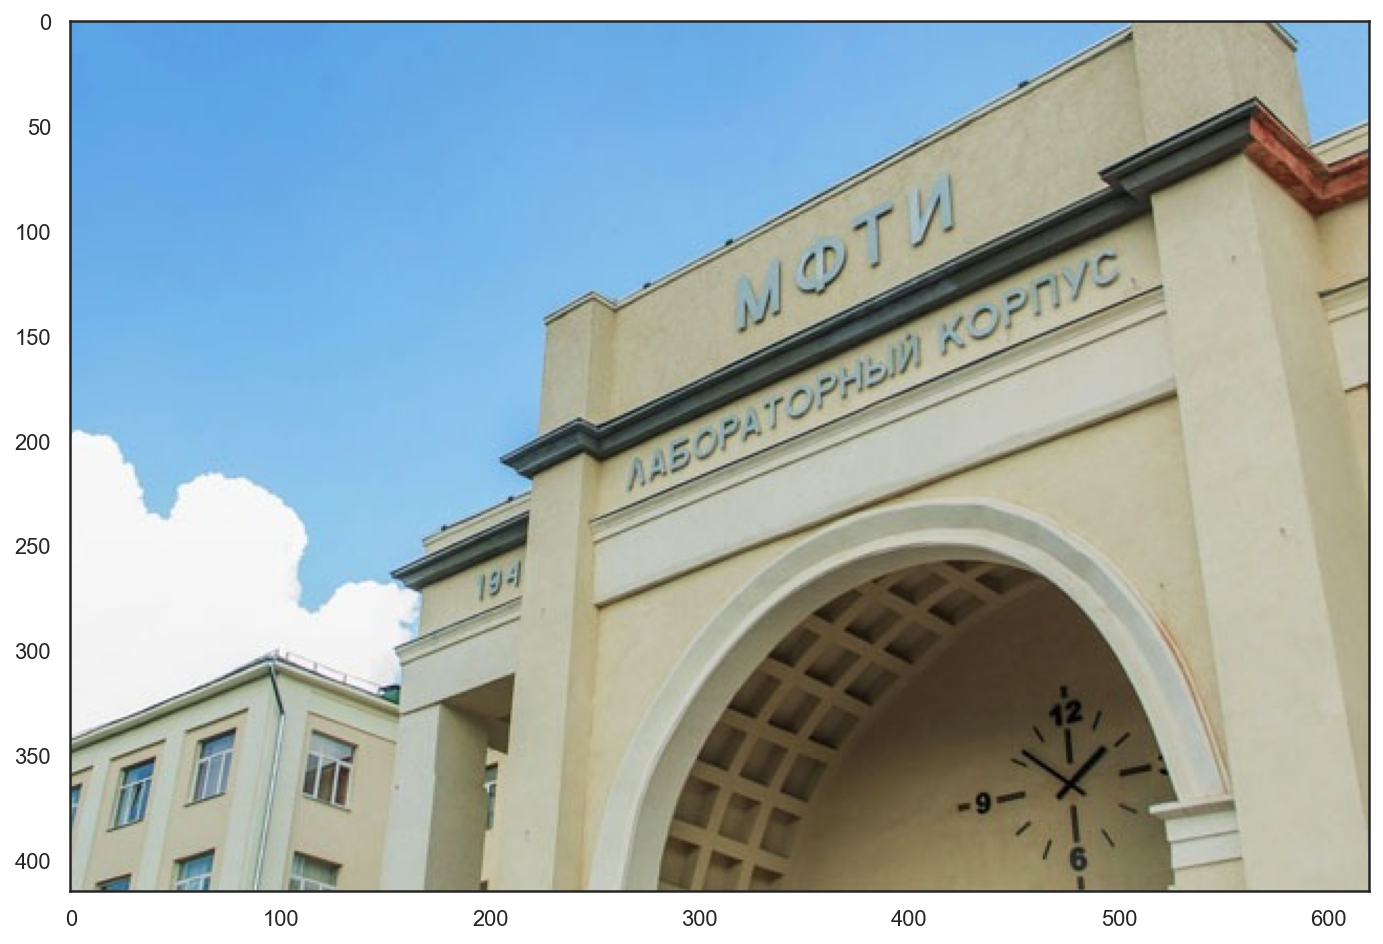

In [31]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте  
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [32]:
convolutions = {
    "А": [[0, 0, 0], [0, 1, 0], [0, 0, 0]],
    "Б": [[0, 1, 0], [0, -2, 0], [0, 1, 0]],
    "В": [[0, 0, 0], [1, -2, 1], [0, 0, 0]],
    "Г": [[0, 1, 0], [1, -4, 1], [0, 1, 0]],
    "Д": [[0, -1, 0], [-1, 5, -1], [0, -1, 0]],
    "Е": [[0.0625, 0.125, 0.0625], [0.125, 0.25, 0.125], [0.0625, 0.125, 0.0625]],
}

In [33]:
def get_result(convolution):
    img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
    kernel = torch.tensor(convolution).reshape(1, 1, 3, 3).type(torch.float32)

    kernel = kernel.repeat(3, 3, 1, 1)
    img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
    img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

    result = Func.conv2d(img_t, kernel)[0]
    result_np = result.permute(1, 2, 0).numpy() / 256 / 3

    return result_np

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


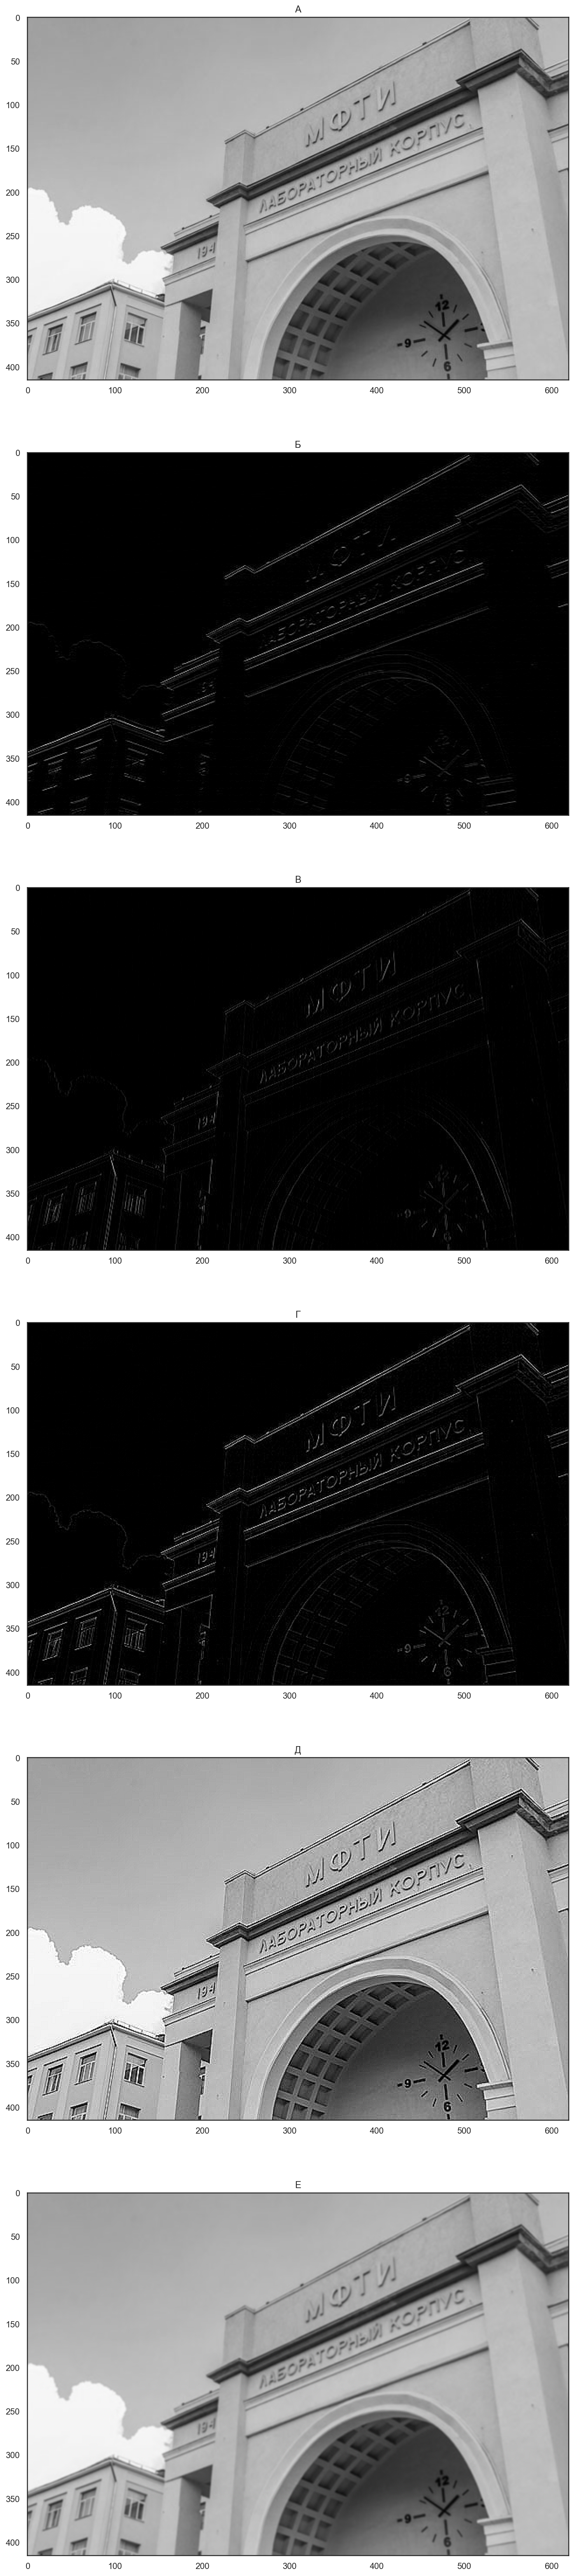

In [34]:
num_conv = len(convolutions)
fig, axs = plt.subplots(
    nrows=num_conv,
    ncols=1,
    figsize=(14 * num_conv, 10 * num_conv),
)
# fig.tight_layout(h_pad=4, w_pad=4)

for ax, convolution in zip(axs, convolutions):
    result_np = get_result(convolutions[convolution])
    ax.imshow(result_np)
    ax.set_title(convolution)
    ax.grid(False)

plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие - **E**

2) Увеличение резкости - **Д**

3) Тождественное преобразование - **А**

4) Выделение вертикальных границ - **В**

5) Выделение горизонтальных границ - **Б**

6) Выделение границ - **Г**

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [35]:
class LeNet(nn.Module):
    def __init__(self, activation_function):
        super(LeNet, self).__init__()
        self.activation_function = activation_function
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2) # YOUR CODE
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3) # YOUR CODE
        self.pool2 = nn.MaxPool2d(kernel_size=2) # YOUR CODE
        self.fc1 = nn.Linear(in_features=6 * 6 * 6, out_features=120) # YOUR CODE  
        self.fc2 = nn.Linear(in_features=120, out_features=84) # YOUR CODE
        self.fc3 = nn.Linear(in_features=84, out_features=10) # YOUR CODE

    def forward(self, x):
        #YOUR CODE. Apply layers created in __init__. 
        x = self.pool1(self.activation_function(self.conv1(x)))
        x = self.pool2(self.activation_function(x))
        # print(x.shape)
        x = x.view(-1, 6 * 6 * 6)  # !!!
        
        x = self.activation_function(self.fc1(x))
        x = self.activation_function(self.fc2(x))
        x = self.fc3(x)
        return x

#### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [36]:
accuracies = {}
for activation_name, activation_func in activation_functions.items():
    model = LeNet(activation_func)
    model = model.to(device)

    accuracies[f"{activation_name}_accuracy"] = test_activation_function(
        activation_func
    )

Testing Identical() function!
LeNet(
  (activation_function): Identical()
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=216, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
Epoch 1
-------------------------------
loss: 2.304629  [    0/60000]
loss: 0.409427  [12800/60000]
loss: 0.224691  [25600/60000]
loss: 0.225422  [38400/60000]
loss: 0.369261  [51200/60000]
Test Error: 
 Accuracy: 93.2%, Avg loss: 0.218436 

Epoch 2
-------------------------------
loss: 0.157881  [    0/60000]
loss: 0.177775  [12800/60000]
loss: 0.134903  [25600/60000]
loss: 0.124845  [38400/60000]
loss: 0.274110  [51200/60000]
Test Error: 
 Accu

Сравним с предыдущем пунктом

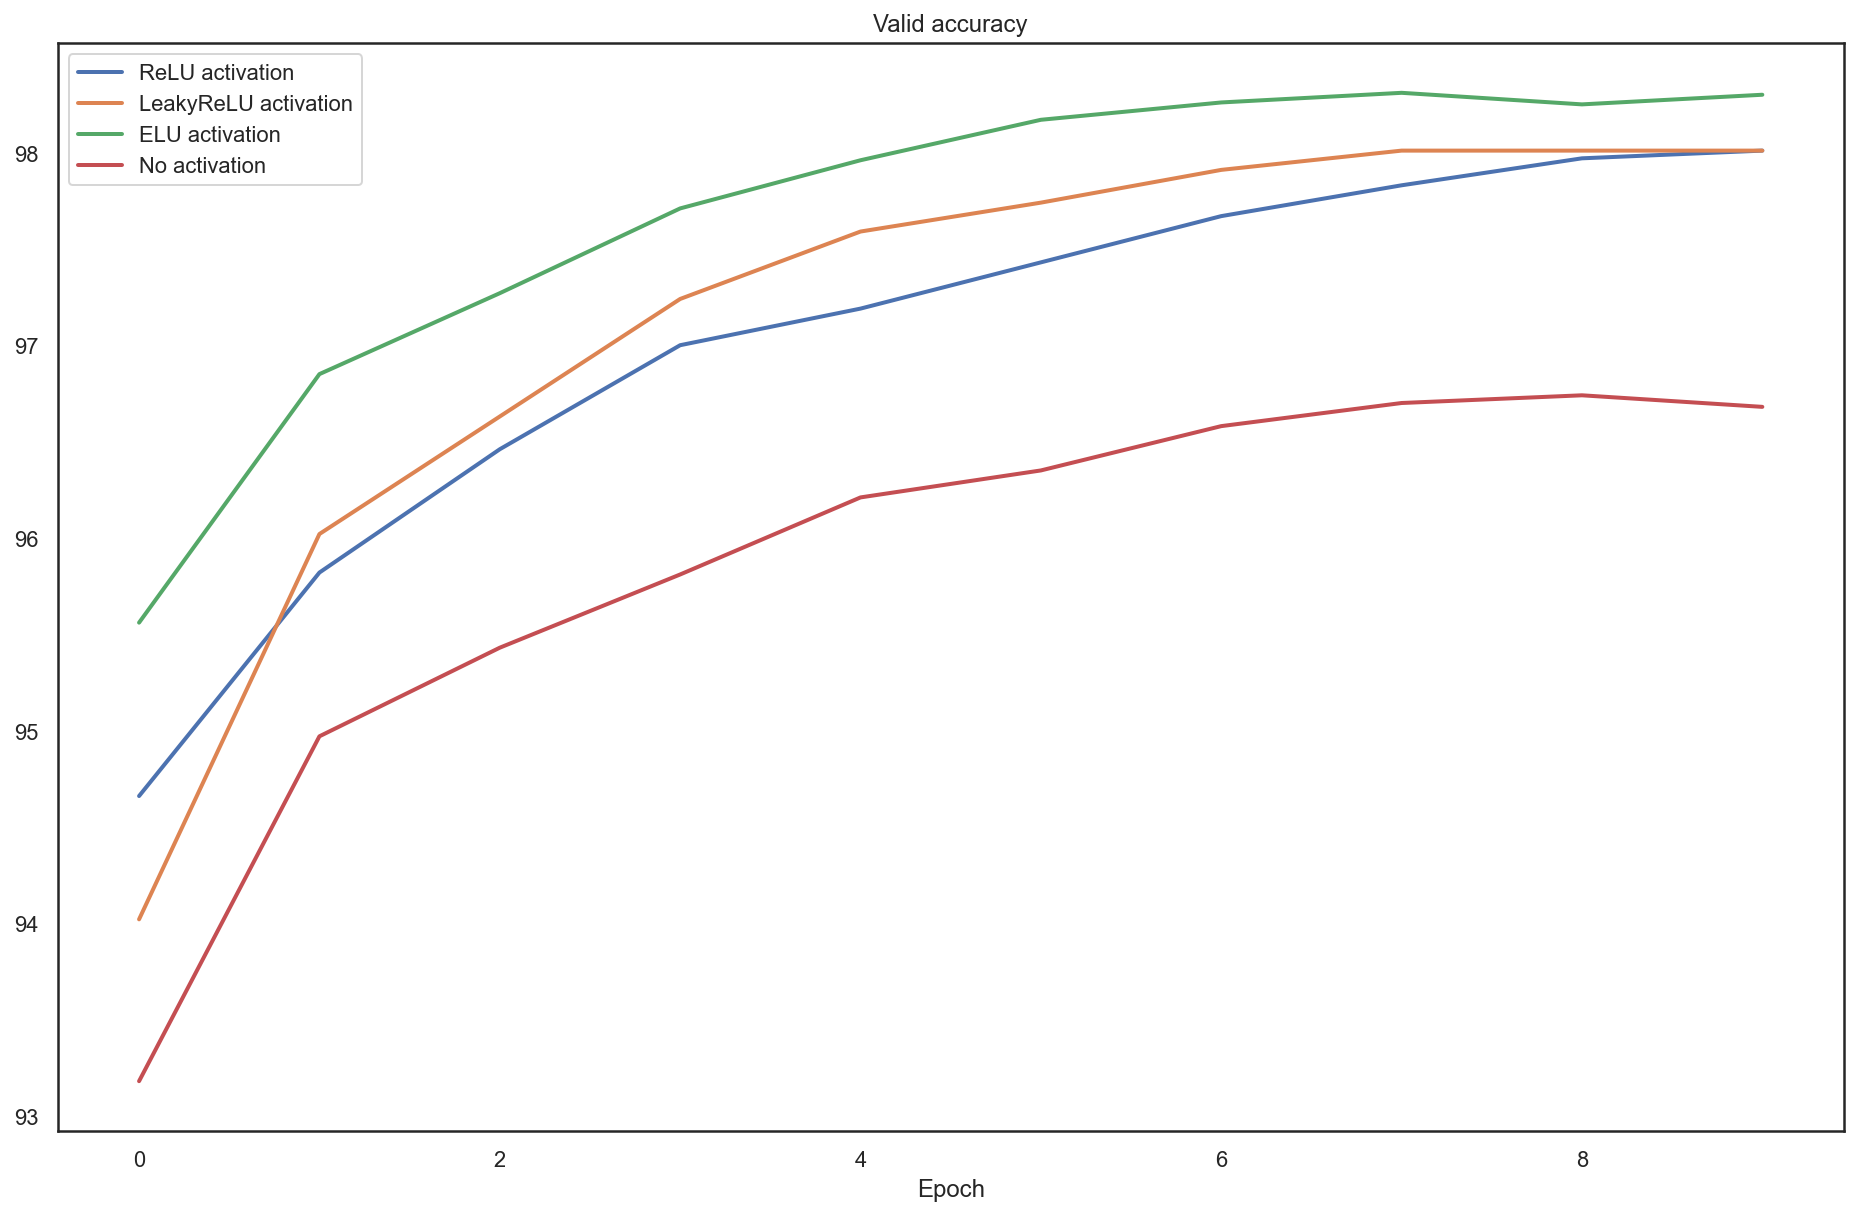

In [37]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), accuracies["ReLU_accuracy"], label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), accuracies["LeakyReLU_accuracy"], label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), accuracies["ELU_accuracy"], label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), accuracies["plain_accuracy"], label="No activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**  
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:**  
98.3 для ELU

In [40]:
accuracies["ELU_accuracy"][-1]

98.3